In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
%matplotlib inline

In [2]:
## Load all the models

haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')

## Pickle files

mean = pickle.load(open('./model/mean_preprocess.pickle' , 'rb'))
model_svm = pickle.load(open('model_svm.pickle', 'rb'))
model_pca = pickle.load(open('./model/pca_50.pickle', 'rb'))

print("Model loaded successfully")

Model loaded successfully


In [12]:
gender_pre = ['Male' , 'Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [14]:
## test data
test_data_path = './data/male_000281.jpg'
color = 'bgr'

## Step 1 : Read Image
img = cv2.imread(test_data_path)


def pipeline_model(img , color="rgb"):
## Step 2 : Convert into gray scale
    if color == 'bgr':
        gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)

    ## Step 3 : Crop the face
    faces = haar.detectMultiScale(gray , 1.5 , 5)
    for x,y,w,h in faces:
        cv2.rectangle(img , (x,y) , (x+w , y+h) , (0,255,0) , 2)
        roi = gray[y:y+h , x:x+w]
        ## Step 4 : Normalization
        roi = roi / 255.0
        ## Step 5 : Resize images
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi , (100,100) , cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi , (100,100) , cv2.INTER_CUBIC)

        ### Step 6 : Flattening
        roi_reshape = roi_resize.reshape(1,10000) ## 1 x 10000

        ## Step 7 : Subtract from mean
        roi_mean = roi_reshape - mean

        ## Step 8 : Get Eigen Image
        eigen_image = model_pca.transform(roi_mean)

        ## Step 9 : Pass to ML model
        results = model_svm.predict_proba(eigen_image)[0]

        ## Step 10 : 
        predict = results.argmax()
        score = results[predict]

        ## Step 11 :
        text = "%s : %0.2f "%(gender_pre[predict] , score)
        cv2.putText(img , text , (x,y) , font , 1 , (0,255,0), 2)

    return img

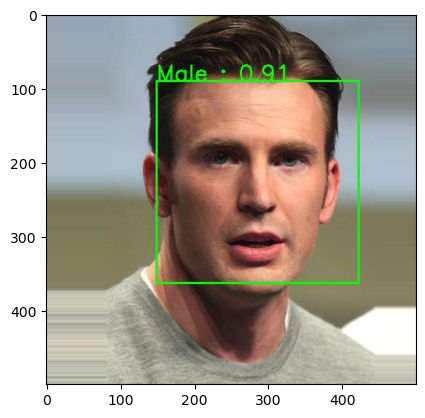

In [16]:
from PIL import Image
test_data_path = './data/male_000281.jpg'
color = 'bgr'
# step-1: read image
img = Image.open(test_data_path) # rgb
# step2: convert into array
img = np.array(img)
# step3: pass to pipeline model
img = pipeline_model(img)
plt.imshow(img)

## Apply pipeline to video

In [17]:
cap = cv2.VideoCapture('./data/video.mp4')

while True:
    ret, frame = cap.read() # bgr
    
    if ret == False:
        break
    
    frame = pipeline_model(frame,color='bgr')
    
    cv2.imshow('Gender Detector',frame)
    if cv2.waitKey(10) == ord('s'): # press s to exit  --#esc key (27), 
        break
        
cv2.destroyAllWindows()
cap.release()